# Battery life cycle prediction

We reproduce the findings reported in the original paper in this section. We use an ElasticNet model as well as Linear and Logistic Regression models. The paper implemented three models: "Variance Model", "Discharge Model" and "Full Model". The modelling approach was to feature engineer features that are linearly correlated to the response. This allows for the use of linear models e.g. Linear and Logistic regression.

Our approach is to recreate and test the original linear models, and then to use Deep Learning techniques to derive the features automatically as an additional step and to compare results.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet, LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
import pickle
import matplotlib.pyplot as plt
import gc
from pathlib import Path
from IPython.display import display

import src.constants as cst
import src.features.rebuilding_features as rf
import src.models.train_model as tm
#from src.data.data_class import BatteryData
#from src.data.load_data import DataLoader
#from src.data.wrangle_data import DataWrangler

#from rebuilding_features import load_batches_to_dict
from src.visualization.helpers import print_dict_keys
from os.path import join
import src.models.data_pipeline as dp

import tensorflow as tf
import pandas as pd
import seaborn as sns
from matplotlib import style
import itertools
import warnings
import json
import seaborn as sns

warnings.filterwarnings('ignore')


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
#session = tf.compat.v1.Session(config=config)
#tf.compat.v1.keras.backend.set_session(session)

DATA_DIR = join("../../data/external")


In [4]:
print (physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Preprocessing and feature selection

We load features we have engineered according to the original paper from file. We used the code from the original paper to perform the feature engineering as a pre-processing step.
The "src/features/rebuilding_features.py" script can be used for generating this dataset from the original data.

In [5]:
# Features built as per the original paper.
features_df = pd.read_csv("../../data/external/rebuild_features.csv")

We split the data into test and training sets. We hold out a secondary testing set for independent testing. This is done according to the methodology used in the original paper.

In [6]:
# Check how many cells of each group of cells with second letter equal to 1,2 or 3 - as per original paper.
numBat1 = len([i for i in list(features_df.cell_key) if i[1] == "1"])
numBat2 = len([i for i in list(features_df.cell_key) if i[1] == "2"])
numBat3 = len([i for i in list(features_df.cell_key) if i[1] == "3"])
numBat = sum((numBat1,numBat2,numBat3))

In [7]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

splits = [train_ind, test_ind, secondary_test_ind]

We now define feature and target columns for the baseline models.

In [8]:
varmod_features = ["variance_dQ_100_10"]

dismod_features = [
    "variance_dQ_100_10",
    "minimum_dQ_100_10",
    "skewness_dQ_100_10",
    "kurtosis_dQ_100_10",
    "discharge_capacity_2",
    "diff_discharge_capacity_max_2",
]

fullmod_features = [
    "minimum_dQ_100_10",
    "variance_dQ_100_10",
    "slope_lin_fit_2_100",
    "intercept_lin_fit_2_100",
    "discharge_capacity_2",
    "mean_charge_time_2_6",
    "minimum_IR_2_100",
    "diff_IR_100_2",
]

targetmod = ["cycle_life"]

# Define feature and target columns for classifiers
varclf_features = ["variance_dQ_5_4"]
fullclf_features = [
    "minimum_dQ_5_4",
    "variance_dQ_5_4",
    "discharge_capacity_2",
    "diff_IR_100_2",
]
targetclf = ["cycle_550_clf"]

In [9]:
# Split data into features and response.
def get_split(data, features, target, split):
    X = data.iloc[split,:].loc[:,features]
    y = data.iloc[split,:].loc[:,target]
    return X, y

# Record regression model performance.
def eval_model(model, data, features, target, split):
    rmse = list()
    mpe = list()
    rsq = list()
    for split in splits:
        X, y = get_split(data, features, target, split)
        y = y.to_numpy()
        pred = model.predict(X)
        rmse.append(np.sqrt(mean_squared_error(pred, y)))
        mpe.append(float(np.mean(np.abs((y - pred.reshape(-1,1))) / y * 100)))
        rsq.append(model.score(X, y))
    return rmse, mpe, rsq

# Record classifier model performance.
def eval_classifier(model, data, features, target, splits):
    acc = list()    
    for split in splits:
        X, y = get_split(data, features, target, split)
        pred = model.predict(X)
        acc.append(accuracy_score(pred, y.values.ravel()))
    return acc

# Variance Model

In [10]:
# Train Elastic net
x_train, y_train = get_split(features_df, varmod_features, targetmod, train_ind)

alphas = np.linspace(0.0001,1,30)
parameters = {
    "alpha": alphas,
    "l1_ratio": [0.001, 0.25, 0.5, 0.75, 1.]
}
enet = ElasticNet(random_state = 54)
regr = GridSearchCV(enet, parameters, cv = 4)
print("Elastic Net R^2: %s" % regr.fit(x_train, y_train).score(x_train, y_train))

lin_reg = LinearRegression()
#print("Linear Regression: %s" % lin_reg.fit(x_train, y_train).score(x_train, y_train))

varmod_rmse, varmod_mpe, varmod_rsq = eval_model(regr, features_df, varmod_features, targetmod, splits)


Elastic Net R^2: 0.778771357057023


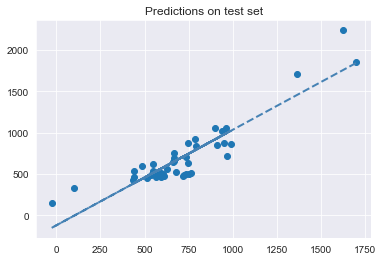

In [11]:
regr = regr.fit(x_train, y_train)
x_test, y_test = get_split(features_df, varmod_features, targetmod, test_ind)
y_pred = regr.predict(x_test)

plt.scatter(y_pred, y_test)
a, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, a*y_pred+b, color='steelblue', linestyle='--', linewidth=2)
#plt.plot(y_pred, y_test, color="red")
plt.title("Predictions on test set")
plt.show()

# Discharge Model

In [12]:
# Train Elastic net
x_train, y_train = get_split(features_df, dismod_features, targetmod, train_ind)

alphas = np.linspace(0.0001, 1, 30)
parameters = {
    "alpha": alphas,
    "l1_ratio": [0.001, 0.25, 0.5, 0.75, 1.]
}
enet = ElasticNet(random_state = 54, max_iter = 1000000)
regr = GridSearchCV(enet, parameters, cv = 4)
print("Elastic Net R^2: %s" % regr.fit(x_train, y_train).score(x_train, y_train))

dismod_rmse, dismod_mpe, dismod_rsq = eval_model(regr, features_df, dismod_features, targetmod, splits)


Elastic Net R^2: 0.8760140929447078


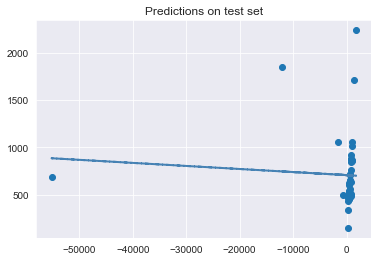

In [13]:
regr = regr.fit(x_train, y_train)
x_test, y_test = get_split(features_df, dismod_features, targetmod, test_ind)
y_pred = regr.predict(x_test)

plt.scatter(y_pred, y_test)
a, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, a*y_pred+b, color='steelblue', linestyle='--', linewidth=2)
#plt.plot(y_pred, y_test, color="red")
plt.title("Predictions on test set")
plt.show()


# Full Model

In [14]:
# Train Elastic net model
x_train, y_train = get_split(features_df, fullmod_features, targetmod, train_ind)

alphas = np.linspace(0.001, 1, 30)
parameters = {
    "alpha": alphas,
    "l1_ratio": [0.001, 0.25, 0.5, 0.75, 1.]
}
enet = ElasticNet(random_state = 54, max_iter=1000000)
regr = GridSearchCV(enet, parameters, cv = 4)
print("Elastic Net R^2: %s" % regr.fit(x_train, y_train).score(x_train, y_train))

fullmod_rmse, fullmod_mpe, fullmod_rsq = eval_model(regr, features_df, fullmod_features, targetmod, splits)

Elastic Net R^2: 0.9206964201191958


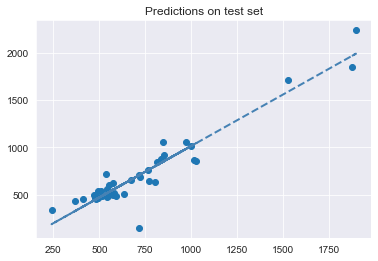

In [15]:
regr = regr.fit(x_train, y_train)
x_test, y_test = get_split(features_df, fullmod_features, targetmod, test_ind)
y_pred = regr.predict(x_test)

plt.scatter(y_pred, y_test)
a, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, a*y_pred+b, color='steelblue', linestyle='--', linewidth=2)
#plt.plot(y_pred, y_test, color="red")
plt.title("Predictions on test set")
plt.show()

# Baseline models RMSE and MPE

In [16]:
reg_results = pd.DataFrame({"Model":["Variance model", "Discharge model", "Full model"],
              "RMSE - Train": [varmod_rmse[0],dismod_rmse[0],fullmod_rmse[0]],
              "RMSE - Primary test": [varmod_rmse[1],dismod_rmse[1],fullmod_rmse[1]],
              "RMSE - Secondary test": [varmod_rmse[2],dismod_rmse[2],fullmod_rmse[2]],
              "MPE - Train": [varmod_mpe[0],dismod_mpe[0],fullmod_mpe[0]],
              "MPE - Primary test": [varmod_mpe[1],dismod_mpe[1],fullmod_mpe[1]],
              "MPE - Secondary test": [varmod_mpe[2],dismod_mpe[2],fullmod_mpe[2]],
              "RSQ - Train": [varmod_rsq[0],dismod_rsq[0],fullmod_rsq[0]],
              "RSQ - Primary test": [varmod_rsq[1],dismod_rsq[1],fullmod_rsq[1]],
              "RSQ - Secondary test": [varmod_rsq[2],dismod_rsq[2],fullmod_rsq[2]]})

display(reg_results)

,Model,RMSE - Train,RMSE - Primary test,RMSE - Secondary test,MPE - Train,MPE - Primary test,MPE - Secondary test,RSQ - Train,RSQ - Primary test,RSQ - Secondary test
0,Variance model,151.983723,169.488406,184.342835,21.219173,21.783186,12.548031,0.778771,0.812269,0.581954
1,Discharge model,113.779118,8798.143718,260.284119,15.900996,234.036648,18.618743,0.876014,-504.869332,0.166575
2,Full model,90.996104,131.012935,265.713679,11.541854,19.138034,20.106816,0.920696,0.887828,0.131441


The "Discharge Model" does not behave correctly. We need to investigate thus further.

There is also too much variance between the primary and secondary test results. This is worrying. The models do not generalise well, and are possibly overfitted.

# Variance Classifier

In [17]:
# Train Logistic Regression
x_train, y_train = get_split(features_df, varclf_features, targetclf, train_ind)

parameters = {"C": [0.01,0.1,0.5,0.75,1]}

logreg = LogisticRegression(solver="liblinear", random_state=54)
clf = GridSearchCV(logreg, parameters, cv=4)
print("Logreg: %s" % clf.fit(x_train, y_train.values.ravel()).score(x_train, y_train.values.ravel()))

varclf_acc = eval_classifier(clf, features_df, varclf_features, targetclf, splits)

Logreg: 0.8048780487804879


# Full Classifier

In [18]:
# Train Logistic Regression
# Why is the full classifier worse than the variance classifier?
x_train, y_train = get_split(features_df, fullclf_features, targetclf, train_ind)

parameters = {"C": [0.01,0.1,0.5,0.75,1]}

logreg = LogisticRegression(solver="liblinear", random_state=54)
clf = GridSearchCV(logreg, parameters, cv=4)
print("Logreg: %s" % clf.fit(x_train, y_train.values.ravel()).score(x_train, y_train.values.ravel()))

fullclf_acc = eval_classifier(clf, features_df, fullclf_features, targetclf, splits)

Logreg: 0.6585365853658537


# Evaluate all classifiers

In [19]:


class_results = pd.DataFrame({"Classifier":["Variance classifier", "Full classifier"],
              "Acc - Train": [varclf_acc[0],fullclf_acc[0]],
              "Acc - Primary test": [varclf_acc[1],fullclf_acc[1]],
              "Acc - Secondary test": [varclf_acc[2],fullclf_acc[2]]})

display(class_results)

,Classifier,Acc - Train,Acc - Primary test,Acc - Secondary test
0,Variance classifier,0.804878,0.767442,0.95
1,Full classifier,0.658537,0.627907,0.60


We obtained roughly similar results to the original paper. Given the small datasets we expected a lot of variation when using these models.

We should spend some more time to see if we can iron some of these problems out (regularisation or reducing complexity of model), but at this point we however have enough information to see how Deep Learning algorithms might perform on this problem.